In [1]:
import os
import sys
import warnings
from datetime import datetime

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scipy
import seaborn as sns
import torch
from albumentations.pytorch.transforms import ToTensorV2
# from packages.lpproj_LPP import LocalityPreservingProjection
from lpproj import LocalityPreservingProjection
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.logging import TensorBoardLogger
from pytorchcv.model_provider import get_model as ptcv_get_model
# from utils import *
from scipy import linalg
from sklearn.metrics import log_loss, roc_auc_score
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST

sys.path.append('../scripts')

warnings.filterwarnings('ignore')


now = datetime.now().strftime("%m%d%H%M")

#### variable

In [2]:
fold_number = 0
batch_size = 256
use_external = True
gpus = [0,1,2,3]


ROOT_PATH = '..'
DATA_PATH = f'{ROOT_PATH}/input/jpeg-melanoma-512x512/'
EXT_DATA_PATH = f'{ROOT_PATH}/input/jpeg-isic2019-512x512/'
TRAIN_ROOT_PATH = f'{DATA_PATH}/train'
EXT_TRAIN_ROOT_PATH = f'{EXT_DATA_PATH}/train'
TEST_ROOT_PATH = f'{DATA_PATH}/test'
CKPT_PATH = f'{ROOT_PATH}/checkpoints/fold{fold_number}_{now}'
LOG_PATH = f'{ROOT_PATH}/logs/fold{fold_number}_{now}'

FEATURES = ["sex", "age_approx", "width", "height", "anatom_site_general_challenge"]

#### data load 

fold,0,1,2
ratio,0.08793,0.08749,0.086636


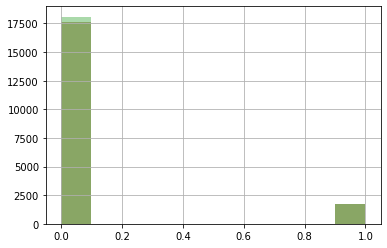

In [3]:
df_train = pd.read_csv(f'{DATA_PATH}/train.csv', index_col="image_name")
df_ext = pd.read_csv(f'{EXT_DATA_PATH}/train.csv', index_col="image_name")

df_train["data_path"] = TRAIN_ROOT_PATH
df_ext["data_path"] = EXT_TRAIN_ROOT_PATH

df_train = pd.concat([df_train, df_ext])
df_train["fold"] = df_train["tfrecord"] %3

df_train = df_train.drop("tfrecord", axis=1)

df_test = pd.read_csv(f'{DATA_PATH}/test.csv', index_col="image_name")
df_test["data_path"] = f"{DATA_PATH}/test"

_ = df_train.groupby('fold').target.hist(alpha=0.4)
df_train.groupby('fold').target.mean().to_frame('ratio').T


#### tableデータの特徴量エンジニアリング

In [4]:
df_concat = pd.concat([df_train, df_test])
df_concat["sex"] = (df_concat["sex"] =="male")
df_concat["age_approx"] = df_concat["age_approx"].fillna(df_concat["age_approx"].mean())
df_concat["anatom_site_general_challenge"] = df_concat["anatom_site_general_challenge"].fillna("unknown")
df_concat["anatom_site_general_challenge"] = df_concat["anatom_site_general_challenge"].map(dict(df_concat["anatom_site_general_challenge"].value_counts()))
df_concat[FEATURES] = (df_concat[FEATURES] - df_concat[FEATURES].mean()) / df_concat[FEATURES].std()

df_train = df_concat.loc[df_train.index]
df_test = df_concat.loc[df_test.index, df_test.columns]

In [5]:
# DATA_PATH = '../input/melanoma-merged-external-data-512x512-jpeg'
# TRAIN_ROOT_PATH = f'{DATA_PATH}/512x512-dataset-melanoma/512x512-dataset-melanoma'
# TEST_ROOT_PATH = f'{DATA_PATH}/512x512-test/512x512-test'

# df_folds = pd.read_csv(f'{DATA_PATH}/folds.csv', index_col='image_id',
#                        usecols=['image_id', 'fold', 'target'], dtype={'fold': np.byte, 'target': np.byte})

# df_test = pd.read_csv(f'../input/siim-isic-melanoma-classification/test.csv', index_col='image_name')

# _ = df_folds.groupby('fold').target.hist(alpha=0.4)
# df_folds.groupby('fold').target.mean().to_frame('ratio').T


In [6]:
resolution = 456
input_res  = 512

def get_train_transforms():
    return A.Compose([
#             A.JpegCompression(p=0.5),
            A.Rotate(limit=45, p=1.0),
            A.OneOf([
                A.OpticalDistortion(),
                A.GridDistortion(),
                A.IAAPiecewiseAffine(),
            ]),
            A.RandomSizedCrop(min_max_height=(int(resolution*0.7), input_res),
                              height=resolution, width=resolution, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.GaussianBlur(p=0.3),
            A.OneOf([
                A.RandomBrightnessContrast(),   
                A.HueSaturationValue(),
            ]),
            A.Cutout(num_holes=8, max_h_size=resolution//8, max_w_size=resolution//8, fill_value=0, p=0.3),
#             A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

def get_fe_transforms():
    return A.Compose([
            A.CenterCrop(height=resolution, width=resolution, p=1.0),
#             A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            A.CenterCrop(height=resolution, width=resolution, p=1.0),
#             A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

def get_tta_transforms():
    return A.Compose([
#             A.JpegCompression(p=0.5),
            A.CenterCrop(height=resolution, width=resolution, p=1.0),
#             A.RandomSizedCrop(min_max_height=(int(resolution*0.9), int(resolution*1.1)),
#                               height=resolution, width=resolution, p=1.0),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.Transpose(p=0.5),
#             A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, df, labels=None, transforms=None, mode="image"):
        super().__init__()
#         self.path = path
        self.df = df
        self.image_ids = df.index.values
        self.data_paths = df.data_path.values
        self.labels = labels
        self.transforms = transforms
        self.mode = mode

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        data_path = self.data_paths[idx]
        image = cv2.imread(f'{data_path}/{image_id}.jpg', cv2.IMREAD_COLOR)
#         print(f'{data_path}/{image_id}.jpg')
        if self.transforms:
            sample = self.transforms(image=image)
            image  = sample['image']
            image = image.float()
            

        label = self.labels[idx] if self.labels is not None else 0.5

        if self.mode=="image":
            return image, label
        else: 
            # self.mode=="full"
            # imageとtable合わせて学習する場合
            x = self.df.loc[image_id, FEATURES]
            x = torch.tensor(x).float()
            return image, x, label
            

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

In [8]:
ds_train = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    df=df_train[df_train['fold'] != fold_number],
    labels=df_train[df_train['fold'] != fold_number].target.values,
    transforms=get_train_transforms(),
)

ds_val = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    # 外部データは除く
    df=df_train[(df_train['fold'] == fold_number) & (df_train["data_path"] ==TRAIN_ROOT_PATH)],
    labels=df_train[(df_train['fold'] == fold_number) & (df_train["data_path"] == TRAIN_ROOT_PATH)].target.values,
    transforms=get_valid_transforms(),
)

ds_test = ImageDataset(
#     path=TEST_ROOT_PATH,
    df=df_test,
    transforms=get_tta_transforms(),
)

ds_train2 = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    df=df_train[df_train['fold'] != fold_number],
    labels=df_train[df_train['fold'] != fold_number].target.values,
    transforms=get_fe_transforms(),
    mode = "full"
)

ds_val2 = ImageDataset(
#     path=TRAIN_ROOT_PATH,
    # 外部データは除く
    df=df_train[(df_train['fold'] == fold_number) & (df_train["data_path"] == TRAIN_ROOT_PATH)],
    labels=df_train[(df_train['fold'] == fold_number) & (df_train["data_path"] == TRAIN_ROOT_PATH)].target.values,
    transforms=get_valid_transforms(),
    mode = "full"
)

ds_test2 = ImageDataset(
#     path=TEST_ROOT_PATH,
    df=df_test,
    transforms=get_tta_transforms(),
    mode = "full"
)

ds_test_tta = ImageDataset(
#     path=TEST_ROOT_PATH,
    df=df_test,
    transforms=get_train_transforms(),
    mode = "full"
)


# del df_train
# len(ds_train), len(ds_val), len(ds_test)

In [9]:
class ConcatModel(pl.LightningModule):

    def __init__(self,image_model,  ds_train, ds_val,ds_test,  batch_size=64,):
            
        super(ConcatModel, self).__init__()
        
        self.image_model = image_model
        self.ds_train = ds_train
        self.ds_val = ds_val
        self.ds_test = ds_test
        self.batch_size = batch_size
        self.input_dim = len(FEATURES)
        self.val_logloss = list()
        self.val_auc = list()
            
        # テーブルデータ用
        self.layer1_1 = torch.nn.Linear(len(FEATURES), 64)     
        self.layer1_2 = torch.nn.Linear(64, 16)
        
        #　 結合データ用
        self.layer2_1 = torch.nn.Linear(self.image_model.n_map_features + self.layer1_2.out_features, 1024)     
        self.layer2_2 = torch.nn.Linear(1024, 512)
        self.layer2_3 = torch.nn.Linear(512, 256)
        self.fc = torch.nn.Linear(256, 1)
        
        self.val_losses = list()

        
    def forward(self, image, x):
        
        # 画像の特徴量抽出
        self.image_model.eval()
        with torch.no_grad():
            x1 = self.image_model(image, feature_extract=True) 
        
        # tableの特徴量抽出
        x2 = self.table_forward(x)
        
        #　くっつける
        x_cat = torch.cat([x1,x2], dim=1)
        
        outputs = self.concat_forward(x_cat)
        
        
        return outputs
    
    def table_forward(self, x):
#         x = x.view(-1, self.input_dim)
        # layer 1-1
        x = self.layer1_1(x)
        x = torch.relu(x)
        # layer 1-2
        x = self.layer1_2(x)
        
        return x
        
    def concat_forward(self, x):
#         x = x.view(-1, self.input_dim)
        # layer 2-1
        x = self.layer2_1(x)
        x = torch.relu(x)
        # layer 2-2
        x = self.layer2_2(x)
        x = torch.relu(x)
        # layer 2-3
        x = self.layer2_3(x)
        x = torch.relu(x)
        x = self.fc(x)
        
        return x
    
    def loss_function(self, y_pred, y_true):
        loss = nn.BCEWithLogitsLoss()
        return loss(y_pred, y_true)
    
    def training_step(self, train_batch, batch_idx):
        image, x, y_true = train_batch
        y_pred = self(image, x).flatten()
        loss = self.loss_function(y_pred, y_true.type_as(y_pred))

        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, val_batch, batch_idx):
        image, x, y_true = val_batch
        logits = self(image, x)
        y_pred = logits.flatten()
        probs = torch.sigmoid(logits)
#         loss = self.loss_function(y_pred, y_true.type_as(y_pred))
#         return {'val_batch_loss': loss, 'probs':probs, 'y_true':y_true}
        return {'probs':probs, 'y_true':y_true}

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        
        y_true = torch.cat([out['y_true'] for out in outputs], dim=0)
        y_true = y_true.detach().cpu().numpy()
        
        self.val_predicts = probs  # Save prediction internally for easy access
        auc_score = roc_auc_score(y_true, probs)
        cross_entropy = log_loss(y_true, probs)
        
        tensorboard_logs = {'valid_logloss': cross_entropy, 'valid_auc':auc_score}
        self.val_logloss.append(cross_entropy)
        self.val_auc.append(auc_score)
        return {'val_loss': cross_entropy, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        image, x, _ = batch

        logits = self(image, x)
        probs = torch.sigmoid(logits)
        
        return {'probs': probs}
    
    def test_epoch_end(self, outputs):
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        self.test_predicts = probs  # Save prediction internally for easy access
        # We need to return something 
        return {'dummy_item': 0}
    
    def prepare_data(self): 
        pass
    
    def train_dataloader(self): 
        return DataLoader(self.ds_train, batch_size=batch_size, num_workers=8, shuffle=True) 

    def val_dataloader(self): 
        return DataLoader(self.ds_val, batch_size=batch_size, num_workers=8) 

    def test_dataloader(self): 
        return DataLoader(self.ds_test, batch_size=batch_size, num_workers=8) 

    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5) 
        return optimizer

In [10]:
class MelanomaModel(pl.LightningModule):

    def __init__(self, ds_train, ds_val, ds_test, output_dim=None):
            
        super(MelanomaModel, self).__init__()
        
        self.ds_train = ds_train
        self.ds_val = ds_val
        self.ds_test = ds_test
        self.val_logloss = list()
        self.val_auc = list()

#         resnet
        self.net = models.resnet18(pretrained=True)
        self.n_map_features = list(self.net.children())[-1].in_features
        self.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=1)
        self.net.fc = nn.Identity()
        
#     #efficientnet
#         self.net = ptcv_get_model("efficientnet_b2b", pretrained=True)
#         self.n_map_features = self.net.output.fc.in_features
#         self.fc = nn.Linear(in_features=self.net.output.fc.in_features, out_features=1)
#         self.net.output.fc = nn.Identity()

        
    def forward(self, x, feature_extract=False):
        x = self.net(x)
        if feature_extract:
            return x
        else:
            x = self.fc(x)
            return x
    
    def loss_function(self, y_pred, y_true):
        loss = nn.BCEWithLogitsLoss()
        return loss(y_pred, y_true)
    
    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self(x).flatten()
        loss = self.loss_function(y_pred, y_true.type_as(y_pred))

        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        logits = self(x)
        y_pred = logits.flatten()
        probs = torch.sigmoid(logits)
#         loss = self.loss_function(y_pred, y_true.type_as(y_pred))
#         return {'val_batch_loss': loss, 'probs':probs, 'y_true':y_true}
        return {'probs':probs, 'y_true':y_true}

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        
        y_true = torch.cat([out['y_true'] for out in outputs], dim=0)
        y_true = y_true.detach().cpu().numpy()
        
        self.val_predicts = probs  # Save prediction internally for easy access
        #from IPython.core.debugger import Pdb; Pdb().set_trace()
        auc_score = roc_auc_score(y_true, probs)
        cross_entropy = log_loss(y_true, probs)
        
        tensorboard_logs = {'valid_logloss': cross_entropy, 'valid_auc':auc_score}
        self.val_logloss.append(cross_entropy)
        self.val_auc.append(auc_score)
        return {'val_loss': cross_entropy, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, _ = batch

        logits = self(x)
        probs = torch.sigmoid(logits)
        
        return {'probs': probs}
    
    def test_epoch_end(self, outputs):
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        self.test_predicts = probs  # Save prediction internally for easy access
        # We need to return something 
        return {'dummy_item': 0}
    
    
    def prepare_data(self): 
        pass
    
    def train_dataloader(self): 
        return DataLoader(self.ds_train, batch_size=batch_size, num_workers=4, shuffle=True) 

    def val_dataloader(self): 
        return DataLoader(self.ds_val, batch_size=batch_size, num_workers=4) 

    def test_dataloader(self): 
        return DataLoader(self.ds_test, batch_size=batch_size, num_workers=4) 

    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5) 
        return optimizer 


In [ ]:
ckpt_path1 = f"{CKPT_PATH}/CNN"
log_path1 = f"{LOG_PATH}/CNN"
os.makedirs(log_path1, exist_ok=True)
os.makedirs(ckpt_path1, exist_ok=True)

tb_log = TensorBoardLogger(save_dir = f"{LOG_PATH}/CNN")

checkpoint_callback = ModelCheckpoint(
    filepath=ckpt_path1,
    save_top_k=4,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='min'
)


# train
model = MelanomaModel(ds_train, ds_val, ds_test) 

trainer = pl.Trainer(max_epochs=10000, logger=tb_log, checkpoint_callback=checkpoint_callback,
                     early_stop_callback=early_stop_callback, gpus=gpus, distributed_backend='dp', num_sanity_val_steps=0)

trainer.fit(model)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 11 M  
1 | fc   | Linear | 513   



Epoch 00000: val_loss reached 0.13329 (best 0.13329), saving model to ../checkpoints/fold0_08051442/CNN/epoch=0.ckpt as top 4



Epoch 00001: val_loss reached 0.08926 (best 0.08926), saving model to ../checkpoints/fold0_08051442/CNN/epoch=1.ckpt as top 4



Epoch 00002: val_loss reached 0.09117 (best 0.08926), saving model to ../checkpoints/fold0_08051442/CNN/epoch=2.ckpt as top 4



Epoch 00003: val_loss reached 0.07645 (best 0.07645), saving model to ../checkpoints/fold0_08051442/CNN/epoch=3.ckpt as top 4



Epoch 00004: val_loss reached 0.07760 (best 0.07645), saving model to ../checkpoints/fold0_08051442/CNN/epoch=4.ckpt as top 4



Epoch 00005: val_loss reached 0.07753 (best 0.07645), saving model to ../checkpoints/fold0_08051442/CNN/epoch=5.ckpt as top 4



Epoch 00006: val_loss reached 0.07657 (best 0.07645), saving model to ../checkpoints/fold0_08051442/CNN/epoch=6.ckpt as top 4



Epoch 00007: val_loss  was not in top 4



Epoch 00008: val_loss reached 0.07339 (best 0.07339), saving model to ../checkpoints/fold0_08051442/CNN/epoch=8.ckpt as top 4



Epoch 00009: val_loss reached 0.07506 (best 0.07339), saving model to ../checkpoints/fold0_08051442/CNN/epoch=9.ckpt as top 4



Epoch 00010: val_loss reached 0.07281 (best 0.07281), saving model to ../checkpoints/fold0_08051442/CNN/epoch=10.ckpt as top 4



Epoch 00011: val_loss reached 0.07080 (best 0.07080), saving model to ../checkpoints/fold0_08051442/CNN/epoch=11.ckpt as top 4



Epoch 00012: val_loss reached 0.07101 (best 0.07080), saving model to ../checkpoints/fold0_08051442/CNN/epoch=12.ckpt as top 4



Epoch 00013: val_loss reached 0.06850 (best 0.06850), saving model to ../checkpoints/fold0_08051442/CNN/epoch=13.ckpt as top 4



Epoch 00014: val_loss reached 0.07129 (best 0.06850), saving model to ../checkpoints/fold0_08051442/CNN/epoch=14.ckpt as top 4



Epoch 00015: val_loss reached 0.07053 (best 0.06850), saving model to ../checkpoints/fold0_08051442/CNN/epoch=15.ckpt as top 4


In [ ]:
ckpt_path2 = f"{CKPT_PATH}/MLP"
log_path2 = f"{LOG_PATH}/MLP"
os.makedirs(log_path2, exist_ok=True)
os.makedirs(ckpt_path2, exist_ok=True)

tb_log2 = TensorBoardLogger(save_dir = f"{LOG_PATH}/MLP")

checkpoint_callback2 = ModelCheckpoint(
    filepath=ckpt_path2,
    save_top_k=4,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

early_stop_callback2 = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='min'
)


concat_model = ConcatModel(model, ds_train2, ds_val2, ds_test2)
trainer2 = pl.Trainer(max_epochs=10000, logger=tb_log2, checkpoint_callback=checkpoint_callback2,
                     early_stop_callback=early_stop_callback2, gpus=gpus, distributed_backend='dp', num_sanity_val_steps=0)


trainer2.fit(concat_model)

#### inference

In [ ]:
trainer2.test(concat_model)

In [ ]:
### TTA
# preds_list = list()

# for i in range(10):
#     trainer2.test(concat_model)
#     preds_list.append(concat_model.test_predicts)

# preds_arr = np.array(preds_list).squeeze()
# new_preds = preds_arr.mean(axis=0)

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}/sample_submission.csv")
submission["target"] = concat_model.test_predicts.squeeze()

#### save

In [ ]:
submission.to_csv(f"{ROOT_PATH}/output/submission.csv", index=False)

In [ ]:
concat_model.val_auc